# Importing libraries

In [2]:
# path handling
import os
# representation of data
import numpy as np
import pandas as pd
# preprocessing 
from bs4 import BeautifulSoup
import re
import string
from nltk.stem import PorterStemmer
from collections import defaultdict, Counter
# visualization
import matplotlib.pyplot as plt
# models 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from scipy.io import loadmat
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,LSTM


# Loading data


In [30]:
spam_2_path='../user/Documents/spam_2/spam_2/'
easy_ham_path='../user/Documents/easy_ham_2/'
hard_ham_path='../user/Documents/hard_ham/hard_ham/'

In [31]:
# function to load the data
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [32]:
spam = get_data(spam_2_path) #1397 spam messages

#1400 non-spam messages ,quite easy to
#differentiate from spam, since they frequently do not contain any spammish
# signatures (like HTML etc)
easy_ham=get_data(easy_ham_path) 

#250 non-spam messages which are closer in many respects to
#typical spam: use of HTML, unusual HTML markup, coloured text,
#"spammish-sounding" phrases etc.
hard_ham=get_data(hard_ham_path)

ham = easy_ham + hard_ham

In [33]:
len(spam)

1397

In [13]:
# an example of a spam email before preprocessing
print(spam[2])

From amknight@mailexcite.com  Mon Jun 24 17:03:49 2002
Return-Path: merchantsworld2001@juno.com
Delivery-Date: Wed May 15 08:58:23 2002
Received: from mandark.labs.netnoteinc.com ([213.105.180.140]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4F7wIe23864 for
    <jm@jmason.org>; Wed, 15 May 2002 08:58:18 +0100
Received: from webcust2.hightowertech.com (webcust2.hightowertech.com
    [216.41.166.100]) by mandark.labs.netnoteinc.com (8.11.2/8.11.2) with
    ESMTP id g4F7wGD24120 for <jm@netnoteinc.com>; Wed, 15 May 2002 08:58:17
    +0100
Received: from html ([206.216.197.214]) by webcust2.hightowertech.com with
    Microsoft SMTPSVC(5.5.1877.197.19); Wed, 15 May 2002 00:55:53 -0700
From: amknight@mailexcite.com
To: cbmark@cbmark.com
Subject: New Improved Fat Burners, Now With TV Fat Absorbers! Time:6:25:49 PM
Date: Wed, 30 Jul 1980 18:25:49
MIME-Version: 1.0
Message-Id: <0845b5355070f52WEBCUST2@webcust2.hightowertech.com>
X-Keywords: 
Content-Type: text/html; charset="DEFA

# préparation des données (Preprocessing)

In [34]:
# function to preprocess the text
def preprocessing(text_list):
    modified_text_list = []
    stemmer = PorterStemmer()
    stem_dict = {}
    for text in text_list:
        #Suppression de balises HTML
        soup = BeautifulSoup(text, 'html.parser')
        modified_text=soup.get_text()
        #Normalisation des URL
        modified_text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE)
        #Normalisation des adresses e-mail
        modified_text =  re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', modified_text, flags=re.MULTILINE)
        #Normalisation des nombres
        modified_text = re.sub(r'\b\d+\b|\d+\.\d+|\d+,\d+|\d+\b', 'nombre', modified_text)
        #Normalisation des dollars
        modified_text = re.sub(r'\$', 'dollar', modified_text)
        #Suppression des non-mots
        #1-Remove non-word characters
        modified_text= re.sub(r'\W+', ' ', modified_text.lower())
        #2- Remove punctuation
        modified_text = modified_text.translate(str.maketrans('', '', string.punctuation)) 
        #Radicalisation de mots
        # split email into words and apply stemming to each word
        stemmed_words = [stemmer.stem(word) for word in modified_text.split()]
        # join the stemmed words back into a string
        modified_text = " ".join(stemmed_words)
        modified_text_list.append(modified_text)
    return modified_text_list


In [35]:
# applying the function to spam and ham data

spam2=preprocessing(spam)
ham2=preprocessing(ham)


In [14]:
# the previous email after preprocessing
print(spam2[2])

from emailaddr mon jun nombr nombr nombr nombr nombr return path emailaddr deliveri date wed may nombr nombr nombr nombr nombr receiv from mandark lab netnoteinc com nombr nombr nombr nombr by dogma slashnul org nombr nombr nombr nombr nombr nombr with esmtp id g4f7wienombr for emailaddr wed nombr may nombr nombr nombr nombr nombr receiv from webcustnombr hightowertech com webcustnombr hightowertech com nombr nombr nombr nombr by mandark lab netnoteinc com nombr nombr nombr nombr nombr nombr with esmtp id g4f7wgdnombr for emailaddr wed nombr may nombr nombr nombr nombr nombr receiv from html nombr nombr nombr nombr by webcustnombr hightowertech com with microsoft smtpsvc nombr nombr nombr nombr nombr wed nombr may nombr nombr nombr nombr nombr from emailaddr to emailaddr subject new improv fat burner now with tv fat absorb time nombr nombr nombr pm date wed nombr jul nombr nombr nombr nombr mime version nombr nombr messag id emailaddr x keyword content type text html charset default ht

# Construction du vocabulaire 

In [36]:
word_counts = defaultdict(int)
for paragraph in spam2:
    for word in paragraph.split():
        word_counts[word] += 1
# getting the words that occur at least 100 times
top_words = [word for word, count in word_counts.items() if count >= 100]
 
# writing the top words to a text file
with open('top_words.txt', mode='w') as file:
    for word in top_words:
        file.write(word + '\n')
        
len(top_words)

1022

In [37]:
with open('top_words.txt', 'r') as file:
    contents = file.read()
    words = contents.split()

    # iterate over the words and add an index to each
    indexed_words = []
    for i, word in enumerate(words):
        indexed_words.append((i, word))

    # write the indexed words to a new file
    with open('indexed_words.txt', 'w') as outfile:
        for index, word in indexed_words:
            outfile.write(str(index) + ' ' + word + '\n')


In [38]:

df_vocab = pd.read_csv('indexed_words.txt', sep=' ',encoding='ISO-8859-1', header=None)
df_vocab.columns = ['index', 'word']
df_vocab.sample(5)


,index,word
202,202,e
231,231,bodi
186,186,open
903,903,fee
275,275,can


# Extraction de caractéristiques


In [52]:
# mapping the words into indices for binary representaion
def get_indices(text):
    df_vocab =  pd.read_csv('indexed_words.txt', sep=' ',encoding='ISO-8859-1', header=None)
    df_vocab.columns = ['index', 'word']
    indices = [df_vocab[df_vocab.word==word]['index'].values[0] for word in text.split() if len(df_vocab[df_vocab.word==word]['index'].values > 0)]
    return indices

In [53]:
word_indices = get_indices(spam2[1])
len(word_indices)

793

In [41]:
#a function to produce a feature vector from the word indices.
def email_features(indices):
    n = 1022 #Total number of words
    x = np.zeros((n,1))
    x[indices]=1
    return x

In [54]:
#example
file_contents = spam2[102]
word_indices1  = get_indices(file_contents)
features = email_features(word_indices1).flatten()
print('Length of feature vector:', len(features))
print('Number of non-zero entries:', sum(features==1))
len(word_indices1)


Length of feature vector: 1022
Number of non-zero entries: 117


377

In [89]:
# Convert each spam email into a vector of features in R^n.
feature_vectors_spam = []
# Iterate over each email
for i in range(len(spam2)):
    # extract features
    word_indices = get_indices(spam2[i])
    
    feature = email_features(word_indices).flatten()
    # Append the feature vector to the list
    feature_vectors_spam.append(feature)

# Convert the list of feature vectors to a NumPy array
feature_array = np.array(feature_vectors_spam)
# getting the data as a dataframe
df_spam = pd.DataFrame(feature_array)
df_spam

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1393,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1394,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1395,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df_spam.to_csv('df_spam.csv', index=False)

In [13]:
# Convert each ham email into a vector of features in R^n.
feature_vectors_ham = []

# Iterate over each email 
for i in range(len(ham2)):
    # extract features
    word_indices = get_indices(ham2[i])
    
    feature = email_features(word_indices).flatten()
    # Append the feature vector to the list
    feature_vectors_ham.append(feature)

# Convert the list of feature vectors to a NumPy array
feature_array = np.array(feature_vectors_ham)
# getting the data as a dataframe
df_ham2 = pd.DataFrame(feature_array)
df_ham2

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1646,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1647,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1648,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_ham2.to_csv('df_ham2.csv', index=False)

# Setting the labels and spilitting the data

In [43]:
df_spam= pd.read_csv('df_spam.csv')
df_spam['label'] = 1
df_ham2=pd.read_csv('df_ham2.csv')
df_ham2['label'] = 0


In [44]:
# merge the two dataframes into one
merged_df = pd.concat([df_spam, df_ham2], ignore_index=True)

In [48]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3043,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3044,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3045,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
y = merged_df.pop('label')
X = merged_df
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [47]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2132, 1022), (915, 1022), (2132,), (915,))

# Classification

## Random forest 

In [81]:
rfc = RandomForestClassifier(n_estimators=1200)
rfc.fit(X_train, y_train)
p = rfc.predict(X_train)
print('Training Accuracy: {0:.2f}%'.format(np.mean((p == y_train).astype(int)) * 100))
p = rfc.predict(X_test)
print('Test Accuracy: {0:.2f}%'.format(np.mean((p == y_test).astype(int)) * 100))

Training Accuracy: 100.00%
Test Accuracy: 97.05%


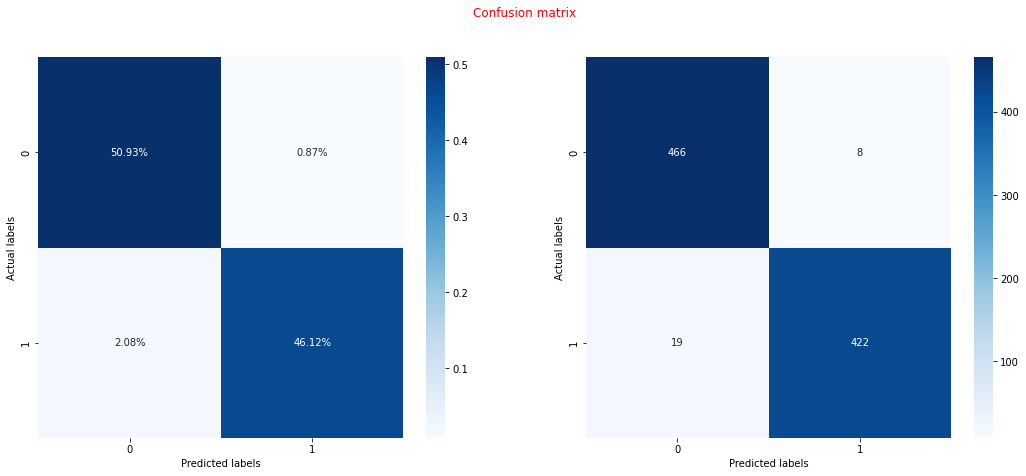

In [83]:
conf_mx = confusion_matrix(y_test, p)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()

## SVM 

In [84]:
y = y.ravel()
svc = svm.SVC(kernel= 'linear',C=0.1)
svc.fit(X_train, y_train)
p = svc.predict(X_train)
print('Training Accuracy: {0:.2f}%'.format(np.mean((p == y_train).astype(int)) * 100))
y_test = y_test.ravel()
p = svc.predict(X_test)

print('Test Accuracy: {0:.2f}%'.format(np.mean((p == y_test).astype(int)) * 100))

Training Accuracy: 100.00%
Test Accuracy: 98.91%


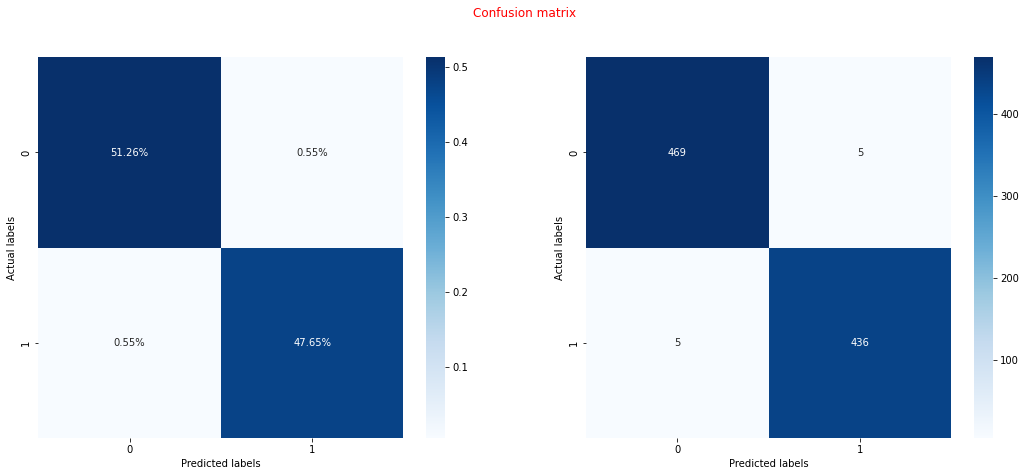

In [85]:
conf_mx = confusion_matrix(y_test, p)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()

# Neural network

In [69]:
# define the model architecture
model = Sequential()

model.add(Dense(32, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# train the model
history = model.fit(X_train, y_train, epochs = 20, batch_size = 8)
# evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:.2f}'.format(accuracy))

Epoch 1/20
267/267 [==============================] - 1s 1ms/step - loss: 0.1633 - accuracy: 0.9400
Epoch 2/20
267/267 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9902
Epoch 3/20
267/267 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.9977
Epoch 4/20
267/267 [==============================] - 1s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 5/20
267/267 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 6/20
267/267 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 7/20
267/267 [==============================] - 0s 1ms/step - loss: 7.7999e-04 - accuracy: 1.0000
Epoch 8/20
267/267 [==============================] - 0s 2ms/step - loss: 5.3786e-04 - accuracy: 1.0000
Epoch 9/20
267/267 [==============================] - 0s 2ms/step - loss: 3.8504e-04 - accuracy: 1.0000
Epoch 10/20
267/267 [==============================] - 0s 2ms/step - loss: 3.0002e-04 - 